# Introduction to LangGraph

Setting up environment

In [1]:
!pip install -U langgraph
!pip install langgraph-sdk
!pip install langgraph-checkpoint-sqlite
!pip install langsmith
!pip install -U langchain-community
!pip install -U langchain-core

!pip install -U langchain_huggingface
!pip install -U langchain_openai

!pip install -U dotenv

!pip install tavily-python
!pip install wikipedia

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.1/44.1 kB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.0/10.0 MB 59.6 MB/s eta 0:00:0000:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 45.8 MB/s eta 0:00:0000:01
  Attempting uninstall: tokenizers
    Found existing installation: tokenizers 0.19.1
    Uninstalling tokenizers-0.19.1:
      Successfully uninstalled tokenizers-0.19.1
  Attempting uninstall: transformers
    Found existing installation: transformers 4.42.4
    Uninstalling transformers-4.42.4:
      Successfully uninstalled transformers-4.42.4
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.5/106.5 kB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 408.0/408.0 kB 21.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 296.9/296.9 kB 19.7 MB/s eta 0:00:00
  Attempting uninstall: langsmith
    Found existing installation: langsmith 0.1.92
    Uninstalling langsmith-0.1.92:
      Successfully uninstalled langsmit

Importing all env vars to enable our integrations

In [1]:
from dotenv import load_dotenv, find_dotenv
_ = load_dotenv(find_dotenv()) # read local .env file

Initialise the ChatGPT 4o

Initialise other tools that we will need

In [2]:
from langchain_openai import ChatOpenAI
from langchain_core.messages import HumanMessage
from langchain_community.tools.tavily_search import TavilySearchResults


In [3]:
msg = HumanMessage(content="Hi there, who are you?", name="Roy")

In [4]:
gpt4o_chat = ChatOpenAI(model="gpt-4o", temperature=0.1)

Checking that all is in order

In [5]:
gpt4o_chat.invoke([msg])

AIMessage(content="Hello! I'm an AI language model created by OpenAI, here to help answer your questions and provide information on a wide range of topics. How can I assist you today?", additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 35, 'prompt_tokens': 16, 'total_tokens': 51, 'completion_tokens_details': {'audio_tokens': None, 'reasoning_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': None, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_45cf54deae', 'finish_reason': 'stop', 'logprobs': None}, id='run-e30a32ef-3fe3-4729-ba9d-6e1e9b6352f4-0', usage_metadata={'input_tokens': 16, 'output_tokens': 35, 'total_tokens': 51, 'input_token_details': {'cache_read': 0}, 'output_token_details': {'reasoning': 0}})

In [7]:
tavily_search = TavilySearchResults(max_results=3)
search_docs = tavily_search.invoke("What kind of platform is Streameye")

In [8]:
search_docs

[{'url': 'https://www.elecard.com/products',
  'content': 'Elecard StreamEye Studio is a set of powerful software tools for video quality analysis designed for professional use in video compression, processing, communication and streaming media industries. ... Professional platform for real-time encoding and transcoding into HEVC/H.265, AVC/H.264 and MPEG-2 video supporting adaptive bitrate streaming ...'},
 {'url': 'https://www.streameye.com/blog/streameye_integrates_with_google_studio',
  'content': "The English sports streaming service DAZN has been relying on StreamEye to be its digital production partner for years. ... seamlessly integrating SteamEye's content production abilities with the analytical powerhouse of Google's Marketing Platform. StreamEye + Google Studio, the Best of Both Worlds. Before this integration, DAZN had one ..."},
 {'url': 'https://videocompressionguru.medium.com/overview-of-elecard-streameye-studio-set-of-applications-1d4d8b0a27ab',
  'content': 'Elecard S

## The Simplest Graph

Simple graph with 3 nodes and conditional edge that would choose which node follows node 1.

![Simple Graph](https://camo.githubusercontent.com/8ec53b6c113f6b577fefce84dd3089bc0d7192ded112d76d464f400c712ae693/68747470733a2f2f63646e2e70726f642e776562736974652d66696c65732e636f6d2f3635623863643732383335636565616364343434396135332f3636646261356634363566366539613234383261643933355f73696d706c652d6772617068312e706e67 "Simple Graph")

### State

Defining the state of the graph. This serves as a shared state along all the nodes and edges of the graph.

Let's use the TypedDict class from python's typing module as our schema, which provides type hints for the keys.

In [11]:
from typing_extensions import TypedDict

class State(TypedDict):
    graph_state: str

### Nodes

Nodes are just Python functions. The first position argument in these functions is the state!

The nodes operate on the state. By default the would overrid the previous state value with new, hence mutating the state.

In [12]:
def node_1(state):
    print("---Node 1---")
    return {"graph_state": state['graph_state'] +" I am"}

def node_2(state):
    print("---Node 2---")
    return {"graph_state": state['graph_state'] +" happy!"}

def node_3(state):
    print("---Node 3---")
    return {"graph_state": state['graph_state'] +" sad!"}

### Edges

Edges connexct the nodes.

Normal edges always go from specific node to next, while conditional apply some logic to route between possible edges.

Conditional edges are implemented as functions that return the next edge to visit based on that logic.

A node can have MULTIPLE outgoing edges. If a node has multiple out-going edges, all of those destination nodes will be executed in parallel as a part of the next superstep.

In [13]:
import random
from typing import Literal

def decide_mood(state) -> Literal["node_2", "node_3"]:
    
    # Often, we will use state to decide on the next node to visit
    # user_input = state['graph_state'] 
    
    # Here, let's just do a 50 / 50 split between nodes 2, 3
    if random.random() < 0.5:

        # 50% of the time, we return Node 2
        return "node_2"
    
    # 50% of the time, we return Node 3
    return "node_3"

### Graph Construction

We can build the graph from the components defined above.

We will use the StateGraph class in this exmaple.

1. Initialise the StateGraph with the `state` defined above.
2. We add the nodes and edges
3. We use the special node `START`, which indicates where to start the graph.
4. Similarly `END` node is a special node that indicates where the graph terminates.

Finally the graph is compiled.

We can visualise the graph via a Mermaid diagram

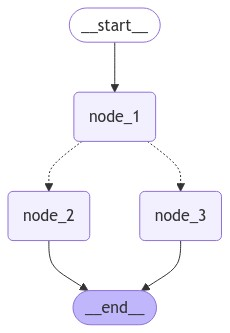

In [14]:
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END

# Build graph
builder = StateGraph(State) # remember State is a class defined above as a 
builder.add_node("node_1", node_1)
builder.add_node("node_2", node_2)
builder.add_node("node_3", node_3)

# Logic
builder.add_edge(START, "node_1")
builder.add_conditional_edges("node_1", decide_mood)
builder.add_edge("node_2", END)
builder.add_edge("node_3", END)

# Add
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

### Graph Invocation

The compiled graph implements the [runnable](https://python.langchain.com/v0.1/docs/expression_language/interface/) protocol.

This interface provides a standard way to execute LangChain commands.

`Invoke` is a method from this interface. The input should be a dictionary of type State which sets the initial state of the graph. E.g. `{"graph_state": "Hi, this is Snoop."}`

When invoke is called, the graph starts execution from the START node.

It progresses through the defined nodes (node_1, node_2, node_3) in order.

The conditional edge will traverse from node 1 to node 2 or 3 using a 50/50 decision rule.

Each node function receives the current state and returns a new value, which overrides the graph state.

The execution continues until it reaches the END node.

`Invoke` runs the whole graph synchrounously. I.e. waiting for each step/ node function to complete before going to the next as defined by the edges. See below:

In [10]:
graph.invoke({"graph_state": "Hi, this is Snoop."})

---Node 1---
---Node 3---


{'graph_state': 'Hi, this is Snoop. I am sad!'}

### Routing to Tools in LangGraph

The idea of this section is to design a graph that would conditionally route execution between a tool node or directly answer a question via an LLM. 

To achieve this we must initialise an LLM like above and register a tool in it. Lets do it below.

In [4]:
from langchain_openai import ChatOpenAI

def multiply(a: int, b: int) -> int:
    """Multiply a and b.

    Args:
        a: first int
        b: second int
    """
    return a * b

llm = ChatOpenAI(model="gpt-4o")
llm_with_tools = llm.bind_tools([multiply])

After this, we can use the following two ideas:

1. Add a node that will call our tool.
    - We use the built-in ToolNode and simply pass a list of our tools to initialize it.
3. Add a conditional edge that will look at the chat model output, and route to our tool calling node or simply end if no tool call is performed.
   - We use the built-in tools_condition as our conditional edge.

>Note: Instead of defining our own State class here, we use the prebuilt MessagesState. The cool thing for this class is that it already has the messages key defined, but also more importantly it uses LangChains add_meesages reducer to add/ append new messages to the state instead of overwriting it.

In [28]:
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END
from langgraph.graph import MessagesState
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition

In [21]:
# Node
def tool_calling_llm(state: MessagesState):
    # messages are appended somehow via this reducer instead of overwritten
    return {"messages": [llm_with_tools.invoke(state["messages"])]} 
# Build the Graph
builder = StateGraph(MessagesState)
builder.add_node("tool_calling_llm", tool_calling_llm)
builder.add_node("tools", ToolNode([multiply]))
builder.add_edge(START, "tool_calling_llm")
builder.add_conditional_edges("tool_calling_llm", tools_condition)
builder.add_edge("tools", END)

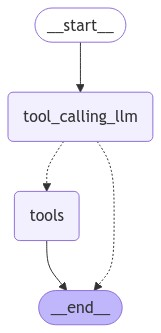

In [22]:
# Compile and View
graph = builder.compile()
display(Image(graph.get_graph().draw_mermaid_png()))

In [31]:
messages = {"messages": "Can you tell me which is the most densely populated country in the world?"}
graph.invoke(messages)

{'messages': [HumanMessage(content='Can you tell me which is the most densely populated country in the world?', id='da40064a-7570-49a2-afcb-baf944e187b5'),
  AIMessage(content='As of the latest data, the most densely populated country in the world is Monaco. Monaco has an extremely high population density due to its small area and relatively large population. The population density of Monaco is over 25,000 people per square kilometer.', response_metadata={'token_usage': {'completion_tokens': 51, 'prompt_tokens': 67, 'total_tokens': 118}, 'model_name': 'gpt-4o-2024-05-13', 'system_fingerprint': 'fp_25624ae3a5', 'finish_reason': 'stop', 'logprobs': None}, id='run-aa174be6-5932-4e46-bbb4-2437ac26cd54-0', usage_metadata={'input_tokens': 67, 'output_tokens': 51, 'total_tokens': 118})]}

In [18]:
tool_message = {"messages": "please multiply 5 and 125"}
response = graph.invoke(tool_message)
for r in response['messages']:
    r.pretty_print()

================================ Human Message =================================

please multiply 5 and 125
================================== Ai Message ==================================
Tool Calls:
  multiply (call_PLIsPkp3sNdLjHbWjHE9B4KW)
 Call ID: call_PLIsPkp3sNdLjHbWjHE9B4KW
  Args:
    a: 5
    b: 125
================================= Tool Message =================================
Name: multiply

625


### Agents

Agents are like Routers but output of the tools are fed back to the edge node (the LLM in this case) and LLM reasons what to do next. Compare the two architectures below:

| Router   | Agent | 
| -------    | ------  |
| ![Router Architecture](https://camo.githubusercontent.com/3e12a13cebe803eca00c2260c9934d5e1dd3a2d17b3075d11859ae36536ae70f/68747470733a2f2f63646e2e70726f642e776562736974652d66696c65732e636f6d2f3635623863643732383335636565616364343434396135332f3636646261633062613062643334623534316334343863635f6167656e74312e706e67 "Router Architecture")     |  ![Agent Architecture](https://camo.githubusercontent.com/f5f9c339b6e85deb9f01b26585c2bbd5cf706cb185dea5606fd02ff778777bca/68747470733a2f2f63646e2e70726f642e776562736974652d66696c65732e636f6d2f3635623863643732383335636565616364343434396135332f3636646261633062346132633165356530326633653738625f6167656e74322e706e67 "Agent Archutecture")    |

In the above router, we invoked the model and, if it chose to call a tool, we returned a ToolMessage to the user.

But, what if we simply pass that ToolMessage back to the model?

We can let it either (1) call another tool or (2) respond directly.

This is the intuition behind ReAct, a general agent architecture.

- **act** - let the model call specific tools
- **observe** - pass the tool output back to the model
- **reason** - let the model reason about the tool output to decide what to do next (e.g., call another tool or just respond directly)

OK, lets give it a go. Let's define few more tools so that we can see if the LLM would reason which to use when.

In [2]:
from modules import OpenLLMCreatorHF

llm_factory = OpenLLMCreatorHF(model="meta-llama/Llama-3.2-3B-Instruct", temperature=0.2, max_tokens=1024, top_p=0.85)
llm = llm_factory.get_from_endpoint()


In [3]:
from langchain_openai import ChatOpenAI
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END
from langgraph.graph import MessagesState
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition

from typing_extensions import TypedDict, Literal

from pydantic import BaseModel, Field
from langchain_core.tools import tool

# @tool(parse_docstring=True)
# def multiply(a: int, b: int) -> int:
#     """Multiply a by b.

#     Args:
#         a: first number
#         b: second number
#     """
#     return a * b

# # This will be a tool
# @tool(parse_docstring=True)
# def add(a: float, b: float) -> float:
#     """Adds a and b.

#     Args:
#         a: first float
#         b: second float
#     """
#     return a + b

# @tool(parse_docstring=True)
# def divide(a: float, b: float) -> float:
#     """Adds a and b.

#     Args:
#         a: first float
#         b: second float
#     """
#     return a / b

# tools = [add, multiply, divide]

# class Multiply(BaseModel):
#     '''Multiplies first argument with second argument, returning a float'''

#     a: int = Field(description="the first argument of the function as integer")
#     b: int = Field(description="the second argument of the function as integer")
    
# @tool(args_schema=Multiply, return_direct=True)
# def multiply(a: int, b: int) -> float:
#     '''Multiplies the first argument by the second argument, returns a float'''

#     return a * b

# class Add(BaseModel):
#     '''Get the current population in a given location'''

#     location: str = Field(description="The city to report population for, e.g. San Francisco")

class Operands(TypedDict):
    a: float
    b: float

class CalculatorModel(BaseModel):
    operands: Operands
    op: Literal["add", "sub", "mult", "div"]

@tool(args_schema=CalculatorModel)
def calculator(operands: Operands, op: Literal["add", "sub", "mult", "div"]) -> float:
    '''Perform basic arithmetic operations on calculator model. Return a float'''
    
    if (op == "add"):
        return operands["a"] + operands["b"]
    elif (op == "mult"):
        return operands["a"] * operands["b"]
    elif (op == 'sub'):
        return operands["a"] - operands["b"]
    elif (op == 'div'):
        return operands["a"] / operands["b"]
    else:
        return -1.

tools = [calculator]
llm_with_tools = llm.bind_tools(tools)

> Here we will create a GPT 4o LLM

In [14]:
llm = ChatOpenAI(model="gpt-4o")
llm_with_tools = llm.bind_tools(tools)

> Here lets try an open source LLM like the Meta LLama 3.1

**IMPORTANT** Currently unable to run tools on local models with ChatHuggingFace. Nor was I able to work with the HuggingFaceEndpoint. The tool returned result, but the LLM kept calling it, reaching the limit of 25 recursive calls.

Potentially try Ollama, ***but for now recommended is to use Groq or try Cerebras which are free and fast.***

Following sections are all commented out for future reference

In [2]:
# upgrading transformers
# !pip install -U transformers

In [2]:
# import torch
# from transformers import (
#     AutoTokenizer,
#     BitsAndBytesConfig,
#     TrainingArguments,
#     AutoModelForCausalLM,
#     DataCollatorForLanguageModeling,
#     GenerationConfig,
#     pipeline
# )

# model_name = "../ext_models/Meta-Llama-3.1-8B-Instruct"
# DEVICE = "cuda:0" if torch.cuda.is_available() else "cpu"

# model = AutoModelForCausalLM.from_pretrained(model_name, trust_remote_code=True, 
#                                              device_map=DEVICE, 
#                                              torch_dtype="auto")
# generation_config = GenerationConfig.from_pretrained(model_name)
# tokenizer = AutoTokenizer.from_pretrained(model_name)

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

In [4]:
# stop_token = "<|eot_id|>"  
# stop_token_id = tokenizer.encode(stop_token)[0]
# begin_token = "<|begin_of_text|>"
# begin_token_id = tokenizer.encode(begin_token)[0]
# generation_config.eos_token_id = stop_token_id
# generation_config.begin_token_id = begin_token_id
# generation_config.max_new_tokens = 1024
# generation_config.temperature = 0.1
# generation_config.top_p = 0.9
# generation_config.do_sample = True
# generation_config.repetition_penalty = 1.15
# generation_config.pad_token_id = tokenizer.eos_token_id


In [5]:
# from langchain_huggingface import HuggingFacePipeline, ChatHuggingFace
# from langchain.prompts import PromptTemplate
# tokenizer.pad_token_id = tokenizer.eos_token_id
# llm_pipeline = pipeline("text-generation", 
#                         model=model, 
#                         tokenizer=tokenizer, 
#                         generation_config=generation_config, 
#                         return_full_text=False) 
# open_llm = HuggingFacePipeline(pipeline=llm_pipeline)
# open_chat = ChatHuggingFace(llm=open_llm, verbose=True)
# llm_with_tools = open_chat.bind_tools(tools)

/opt/conda/lib/python3.11/site-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


So we are stuck here pretty much. We need to have this extended to open source agents.

OK - so lets try the ChatHugginFace class.

Let's create our LLM and prompt it with the overall desired agent behavior.

### Using HF Endpoint instead

In [2]:
# from langchain_huggingface import HuggingFaceEndpoint, ChatHuggingFace

# from dotenv import load_dotenv, find_dotenv
# _ = load_dotenv(find_dotenv()) # read local .env file

# open_llm = HuggingFaceEndpoint(
#     repo_id="meta-llama/Llama-3.2-3B-Instruct",
#     # repo_id="microsoft/Phi-3-mini-4k-instruct",
#     task="text-generation",
#     max_new_tokens=1024,
#     do_sample=True,
#     repetition_penalty=1.1,
# )
# chat = ChatHuggingFace(llm=open_llm, verbose=True)
chat_with_tools = chat.bind_tools(tools=simple_tool)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [4]:
from langgraph.graph import MessagesState
from langchain_core.messages import HumanMessage, SystemMessage

In [5]:
# System message - we will add a system message this time
sys_msg = SystemMessage(content="You are a helpfull assistant tasked with performing arithmetic operations on set of inputs.")

# The Assistant Node
def assistant(state: MessagesState):
    return {"messages": [llm_with_tools.invoke([sys_msg] + state["messages"])]}
### The below was me trying to convert messages into another form, but it was all waste of time since 
### the MessagesState uses a reducer with HumanMessage, AIMessage formatting
    
# def open_assistant(state: MessagesState):

#     print("state", state["messages"])
#     m = [{"role": "system", "content": "You are a very helpful assistant, tasked with performing arithmetic operations on set of inputs."},
#          {"role": "user", "content": "can you multiply 3 by 2 please"}]

#     templated = tokenizer.apply_chat_template(m, tokenize=False )
#     print("TMPL", templated)
#     result = llm_with_tools.invoke(m)
#     print("RES", result)
#     return {"messages": [result]}

As before, we use MessagesState and define a Tools node with our list of tools.

We create a graph with Assistant and Tools nodes.

We add `tools_condition` edge, which routes to End or to Tools based on whether the Assistant calls a tool.

*Now, we add one new step:*

We connect the Tools node back to the Assistant, forming a loop.

- After the assistant node executes, tools_condition checks if the model's output is a tool call.
- If it is a tool call, the flow is directed to the tools node.
- The tools node connects back to assistant.
- This loop continues as long as the model decides to call tools.
- If the model response is not a tool call, the flow is directed to END, terminating the process.

In [6]:
builder = StateGraph(MessagesState)
builder.add_node("assistant", assistant)
builder.add_node("tools", ToolNode(tools))
builder.add_edge(START, "assistant")
# tools_condition is a ready to use conditional function that would route to tool or END automatically.
# If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
# If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
builder.add_conditional_edges("assistant", tools_condition)
# below is the loop, instead of routing tools to END and finishing on the first cycle of the GRAPH we loop back to the Assistant
builder.add_edge("tools", "assistant")

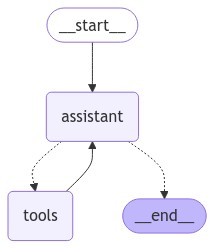

In [7]:
react_graph = builder.compile()

# Show
display(Image(react_graph.get_graph(xray=True).draw_mermaid_png()))

In [8]:
messages = [HumanMessage(content="Multiply 6 by 6 and add 315 divided by 15 to the product")]

result = react_graph.invoke({"messages": messages})

/opt/conda/lib/python3.11/site-packages/huggingface_hub/inference/_generated/types/base.py:139: FutureWarning: Accessing 'ChatCompletionOutputToolCall' values through dict is deprecated and will be removed from version '0.25'. Use dataclass attributes instead.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/huggingface_hub/inference/_generated/types/base.py:139: FutureWarning: Accessing 'ChatCompletionOutputToolCall' values through dict is deprecated and will be removed from version '0.25'. Use dataclass attributes instead.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/huggingface_hub/inference/_generated/types/base.py:139: FutureWarning: Accessing 'ChatCompletionOutputToolCall' values through dict is deprecated and will be removed from version '0.25'. Use dataclass attributes instead.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/huggingface_hub/inference/_generated/types/base.py:139: FutureWarning: Accessing 'ChatCompletionOutputToolCall' values through

GraphRecursionError: Recursion limit of 25 reached without hitting a stop condition. You can increase the limit by setting the `recursion_limit` config key.
For troubleshooting, visit: https://python.langchain.com/docs/troubleshooting/errors/GRAPH_RECURSION_LIMIT

In [ ]:
for m in result['messages']:
    m.pretty_print()


### Memory

Extending our agent with memory. Same tools apply!

if we add another prompt like: "Multiply that by 2", the model does not know what "that" is. State is transient to single graph execution.

We have to address this via persistence.

LangGraph can use a checkpointer to automatically save the graph state after each step.

This built-in persistence layer gives us memory, allowing LangGraph to pick up from the last state update.

One of the easiest checkpointers to use is the MemorySaver, an in-memory key-value store for Graph state.

All we need to do is simply compile the graph with a checkpointer, and our graph has memory!

In [16]:
from langgraph.checkpoint.memory import MemorySaver
memory = MemorySaver()

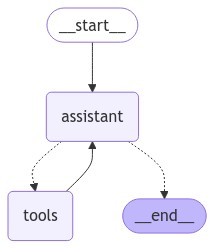

In [17]:
react_graph_mem = builder.compile(checkpointer=memory)

# Show
display(Image(react_graph_mem.get_graph(xray=True).draw_mermaid_png()))

When we use memory we need to specify a thread_id, which will store our collection of graph states (or checkpoints).

We can access this thread later using this ID.

In [18]:
# specify the thread_id as part of a config

config = {"configurable": {"thread_id": 1}}

In [20]:
messages = [HumanMessage(content="Multiply 5 and 7")]

In [21]:
# run the model on the messages
result = react_graph_mem.invoke({"messages": messages}, config=config)

In [22]:
for r in result["messages"]:
    r.pretty_print()

================================ Human Message =================================

Multiply 5 and 7
================================== Ai Message ==================================
Tool Calls:
  calculator (call_DBf6J1k0bpTa3w51rNDPeSJc)
 Call ID: call_DBf6J1k0bpTa3w51rNDPeSJc
  Args:
    operands: {'a': 5, 'b': 7}
    op: mult
================================= Tool Message =================================
Name: calculator

35.0
================================== Ai Message ==================================

The result of multiplying 5 and 7 is 35.


In [23]:
messages = [HumanMessage(content="Add that to 211 and divide the result by 8")]
result = react_graph_mem.invoke({"messages": messages}, config=config)
for r in result["messages"]:
    r.pretty_print()

================================ Human Message =================================

Multiply 5 and 7
================================== Ai Message ==================================
Tool Calls:
  calculator (call_DBf6J1k0bpTa3w51rNDPeSJc)
 Call ID: call_DBf6J1k0bpTa3w51rNDPeSJc
  Args:
    operands: {'a': 5, 'b': 7}
    op: mult
================================= Tool Message =================================
Name: calculator

35.0
================================== Ai Message ==================================

The result of multiplying 5 and 7 is 35.
================================ Human Message =================================

Add that to 211 and divide the result by 8
================================== Ai Message ==================================
Tool Calls:
  calculator (call_uHuAs15DMjLAp3Jfjoas2FCx)
 Call ID: call_uHuAs15DMjLAp3Jfjoas2FCx
  Args:
    operands: {'a': 35, 'b': 211}
    op: add
================================= Tool Message =================================
Name: 

In [24]:
messages = [HumanMessage(content="If the result is in cm, how many inches would that be?")]
result = react_graph_mem.invoke({"messages": messages}, config=config)
for r in result["messages"]:
    r.pretty_print()

================================ Human Message =================================

Multiply 5 and 7
================================== Ai Message ==================================
Tool Calls:
  calculator (call_DBf6J1k0bpTa3w51rNDPeSJc)
 Call ID: call_DBf6J1k0bpTa3w51rNDPeSJc
  Args:
    operands: {'a': 5, 'b': 7}
    op: mult
================================= Tool Message =================================
Name: calculator

35.0
================================== Ai Message ==================================

The result of multiplying 5 and 7 is 35.
================================ Human Message =================================

Add that to 211 and divide the result by 8
================================== Ai Message ==================================
Tool Calls:
  calculator (call_uHuAs15DMjLAp3Jfjoas2FCx)
 Call ID: call_uHuAs15DMjLAp3Jfjoas2FCx
  Args:
    operands: {'a': 35, 'b': 211}
    op: add
================================= Tool Message =================================
Name: 

### Overwriting State

Let's use a TypedDict for our state schema.

In [38]:
from typing_extensions import TypedDict
from dataclasses import dataclass
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END

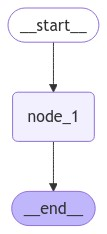

In [3]:
class State(TypedDict):
    foo: int
def node_1(state):
    print("node_1")
    return({"foo": state["foo"] + 1})
builder = StateGraph(State)
builder.add_node("node_1", node_1)
builder.add_edge(START, "node_1")
builder.add_edge("node_1", END)

graph = builder.compile()

display(Image(graph.get_graph(xray=True).draw_mermaid_png()))

In [4]:
graph.invoke({"foo": 33})

node_1


{'foo': 34}

### Using Reducers

We should use reducers mainly when we perform state updates in parallel. This will result in an error since each node will update the same key in the state. Hence we need a way to append to existing list of values rather than overwrite existing value.

This is where reducers come in. We will be using the built-in operator 'add' in python as a function in our reducer.



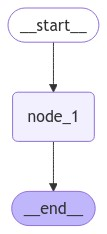

In [22]:
from operator import add
from typing import Annotated

class State(TypedDict):
    foo: Annotated[list[int], add]

def node_1(state):
    print("---Node 1---")
    return {"foo": [state['foo'][-1] + 2]}

# Build graph
builder = StateGraph(State)
builder.add_node("node_1", node_1)

# Logic
builder.add_edge(START, "node_1")
builder.add_edge("node_1", END)

# Add
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [23]:
graph.invoke({"foo": [9]})

---Node 1---


{'foo': [9, 11]}

In [18]:
arr = [1,2,3,4]

arred = add(arr, [arr[-1] + 1])
arred

[1, 2, 3, 4, 5]

So it seems that when we pass State to graph it adds current state with current value. It passess to operator.add(state['foo'], whatever the return is from the node)

i.e. `add(state['foo'], [state['foo'][-1] + 2])` as in the example above

lets try the branching with parallel state updates

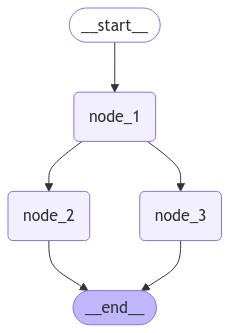

In [32]:
def node_1(state):
    print("---Node 1---")
    return {"foo": [state['foo'][-1] + 1]}

def node_2(state):
    print("---Node 2---")
    return {"foo": [state['foo'][-1] + 1]}

def node_3(state):
    print("---Node 3---")
    return {"foo": [state['foo'][-1] + 1]}

# Build graph
builder = StateGraph(State)
builder.add_node("node_1", node_1)
builder.add_node("node_2", node_2)
builder.add_node("node_3", node_3)

# Logic
builder.add_edge(START, "node_1")
builder.add_edge("node_1", "node_2")
builder.add_edge("node_1", "node_3")
builder.add_edge("node_2", END)
builder.add_edge("node_3", END)

# Add
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [35]:
graph.invoke({'foo': [1]})

---Node 1---
---Node 2---
---Node 3---


{'foo': [1, 2, 3, 3]}

This results in the initial state `[1]` then in node_1 it adds `[2]` and node_2 and node_3 add the same `[3]` simultaneously

Below we will implement custom reducer `reduce_list` which takes two lists and handles `None` being supplied instead of a list as an argument.

In [39]:
def reduce_list(left: list | None, right: list | None):
    """Safely combine two lists, handling cases where either or both inputs might be None.

    Args:
        left (list | None): The first list to combine, or None.
        right (list | None): The second list to combine, or None.

    Returns:
        list: A new list containing all elements from both input lists.
               If an input is None, it's treated as an empty list.
    """
    if not left:
        left = []
    if not right:
        right = []
    return left + right



@dataclass
class DataClassState:
    foo: Annotated[list[int], reduce_list]

class DefaultState:
    foo: Annotated[list[int], add]

def node_1(state):
    print("---Node 1---")
    return {"foo": [2]}

# Build graph
builder = StateGraph(DataClassState)
builder.add_node("node_1", node_1)

# Logic
builder.add_edge(START, "node_1")
builder.add_edge("node_1", END)

# Add
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

try:
    print(graph.invoke({"foo" : None}))
except TypeError as e:
    print(f"TypeError occurred: {e}")

NameError: name 'Annotated' is not defined

### Filtering and Trimming Messages

Let's start by creating a simple chat with some initial messages



In [13]:
from dotenv import load_dotenv, find_dotenv
_ = load_dotenv(find_dotenv()) # read local .env file
from langgraph.graph import MessagesState, START, END, StateGraph
from pprint import pprint
from langchain_core.messages import HumanMessage, SystemMessage, AIMessage
from langgraph.checkpoint.memory import MemorySaver
from langchain_openai import ChatOpenAI
from IPython.display import Image, display


messages = [HumanMessage("Hey AI can you answer some animal questions?"), AIMessage("Sure, go ahead and ask, I am here to assist")]
messages.append(HumanMessage("I am interested to know which of the creatures currently inhabiting Earth has the longest lifespan. \
Which creature lives the longest?"))

sys_message = SystemMessage("You are an everhelpful assistant trying to assist your human friend. You are polite, thoughtful \
and with great sense of humour.")

In [14]:
llm = ChatOpenAI(model="gpt-4o", temperature=0.75)
memory = MemorySaver()

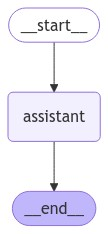

In [15]:
# The Assistant Node
def assistant(state: MessagesState):
    return {"messages": [llm.invoke([sys_message] + state["messages"])]}
builder = StateGraph(MessagesState)
builder.add_node("assistant", assistant)
builder.add_edge(START, "assistant")
builder.add_edge("assistant", END)

graph = builder.compile(checkpointer=memory)

display(Image(graph.get_graph().draw_mermaid_png()))


In [75]:
r = graph.invoke({"messages": messages}, config={"configurable": {"thread_id": 42}})

In [77]:
for item in r["messages"]:
    item.pretty_print()

================================ Human Message =================================

Hey AI can you answer some animal questions?
================================== Ai Message ==================================

Sure, go ahead and ask, I am here to assist
================================ Human Message =================================

I am interested to know which of the creatures currently inhabiting Earth has the longest lifespan. Which creature lives the longest?
================================== Ai Message ==================================

Ah, the quest for immortality through the animal kingdom! The creature with the longest lifespan is the ocean quahog clam (*Arctica islandica*), some of which have been known to live over 500 years. One particular clam, nicknamed "Ming," was found to be 507 years old! Talk about a slow pace of life.

If you're wondering about vertebrates, the Greenland shark (*Somniosus microcephalus*) holds the record, with some individuals estimated to live up

In [78]:
r = graph.invoke({"messages": [HumanMessage("Isn't there some jellyfish that lives longer?")]}, config={"configurable": {"thread_id": 42}})
for item in r["messages"]:
    item.pretty_print()

================================ Human Message =================================

Hey AI can you answer some animal questions?
================================== Ai Message ==================================

Sure, go ahead and ask, I am here to assist
================================ Human Message =================================

I am interested to know which of the creatures currently inhabiting Earth has the longest lifespan. Which creature lives the longest?
================================== Ai Message ==================================

Ah, the quest for immortality through the animal kingdom! The creature with the longest lifespan is the ocean quahog clam (*Arctica islandica*), some of which have been known to live over 500 years. One particular clam, nicknamed "Ming," was found to be 507 years old! Talk about a slow pace of life.

If you're wondering about vertebrates, the Greenland shark (*Somniosus microcephalus*) holds the record, with some individuals estimated to live up

In [79]:
r = graph.invoke({"messages": [HumanMessage("How big is it? Where does it live?")]}, config={"configurable": {"thread_id": 42}})
for item in r["messages"]:
    item.pretty_print()

================================ Human Message =================================

Hey AI can you answer some animal questions?
================================== Ai Message ==================================

Sure, go ahead and ask, I am here to assist
================================ Human Message =================================

I am interested to know which of the creatures currently inhabiting Earth has the longest lifespan. Which creature lives the longest?
================================== Ai Message ==================================

Ah, the quest for immortality through the animal kingdom! The creature with the longest lifespan is the ocean quahog clam (*Arctica islandica*), some of which have been known to live over 500 years. One particular clam, nicknamed "Ming," was found to be 507 years old! Talk about a slow pace of life.

If you're wondering about vertebrates, the Greenland shark (*Somniosus microcephalus*) holds the record, with some individuals estimated to live up

Let's try and filter some messages out. For example the below will be deleting all but the last two messages using the `RemoveMessage` function

In [16]:
from langchain_core.messages import RemoveMessage, trim_messages

def filter_messages(state: MessagesState):
    delete_messages = [RemoveMessage(id=m.id) for m in state["messages"][:-4]] # this returns all but the last two messages
    return {"messages": delete_messages}
def assistant_with_trim(state: MessagesState):
    trimmed = trim_messages(
            state["messages"],
            max_tokens=250,
            strategy="last",
            token_counter=ChatOpenAI(model="gpt-4o"),
            allow_partial=False
        )
    return {"messages": [llm.invoke([sys_message] + trimmed)]}

Now we can add the above function as a node before the Assistant. So the Assistant would only see the last two messages.

In [10]:
builder = StateGraph(MessagesState)
builder.add_node("assistant", assistant)
builder.add_node("filter", filter_messages)
builder.add_edge(START, "filter")
builder.add_edge("filter", "assistant")
builder.add_edge("assistant", END)

graph = builder.compile(checkpointer=memory)

display(Image(graph.get_graph().draw_mermaid_png()))

NameError: name 'assistant' is not defined

In [110]:
messages_so_far.append(HumanMessage("Well if this jellyfish does not really die off, wouldn't we be swamped with the little creatures, sooner or later?"))

[HumanMessage(content='Hey AI can you answer some animal questions?', additional_kwargs={}, response_metadata={}, id='0a4f5501-9076-4c4b-8bca-d982ff5be893'),
 AIMessage(content='Sure, go ahead and ask, I am here to assist', additional_kwargs={}, response_metadata={}, id='ffe4c684-3b4d-47f5-bc59-f4b720a5c7b9'),
 HumanMessage(content='I am interested to know which of the creatures currently inhabiting Earth has the longest lifespan. Which creature lives the longest?', additional_kwargs={}, response_metadata={}, id='c74388a7-8d81-4376-80a2-0bf9e9f3307e'),
 AIMessage(content='Ah, the quest for immortality through the animal kingdom! The creature with the longest lifespan is the ocean quahog clam (*Arctica islandica*), some of which have been known to live over 500 years. One particular clam, nicknamed "Ming," was found to be 507 years old! Talk about a slow pace of life.\n\nIf you\'re wondering about vertebrates, the Greenland shark (*Somniosus microcephalus*) holds the record, with some i

In [17]:
messages_so_far = [HumanMessage(content='Hey AI can you answer some animal questions?', additional_kwargs={}, response_metadata={}, id='0a4f5501-9076-4c4b-8bca-d982ff5be893'),
 AIMessage(content='Sure, go ahead and ask, I am here to assist', additional_kwargs={}, response_metadata={}, id='ffe4c684-3b4d-47f5-bc59-f4b720a5c7b9'),
 HumanMessage(content='I am interested to know which of the creatures currently inhabiting Earth has the longest lifespan. Which creature lives the longest?', additional_kwargs={}, response_metadata={}, id='c74388a7-8d81-4376-80a2-0bf9e9f3307e'),
 AIMessage(content='Ah, the quest for immortality through the animal kingdom! The creature with the longest lifespan is the ocean quahog clam (*Arctica islandica*), some of which have been known to live over 500 years. One particular clam, nicknamed "Ming," was found to be 507 years old! Talk about a slow pace of life.\n\nIf you\'re wondering about vertebrates, the Greenland shark (*Somniosus microcephalus*) holds the record, with some individuals estimated to live up to 400 years. Clearly, the secret to a long life involves living in cold, deep waters and moving at a glacial pace. Maybe we should take notes?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 136, 'prompt_tokens': 90, 'total_tokens': 226, 'completion_tokens_details': {'audio_tokens': None, 'reasoning_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': None, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_a20a4ee344', 'finish_reason': 'stop', 'logprobs': None}, id='run-61dcc765-b95a-45ec-affd-0e1aa5eb9c85-0', usage_metadata={'input_tokens': 90, 'output_tokens': 136, 'total_tokens': 226, 'input_token_details': {'cache_read': 0}, 'output_token_details': {'reasoning': 0}}),
 HumanMessage(content="Isn't there some jellyfish that lives longer?", additional_kwargs={}, response_metadata={}, id='7b0088d3-e244-482d-bc2f-4393c3fd49e8'),
 AIMessage(content='Ah, you\'re thinking of the infamous *Turritopsis dohrnii*, often dubbed the "immortal jellyfish." This little marvel of the sea has a fascinating trick up its tentacles: it can revert its cells to an earlier stage of development when it faces environmental stress or injury, essentially starting its life cycle over again. It\'s like being able to hit a biological "reset" button, which theoretically means it could live indefinitely under the right conditions. \n\nHowever, while this jellyfish can potentially keep resetting its life clock, it doesn\'t make them invincible—they still face threats from predators and disease. So, while not immortal in the traditional sense, *Turritopsis dohrnii* certainly has mastered the art of a comeback!', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 150, 'prompt_tokens': 244, 'total_tokens': 394, 'completion_tokens_details': {'audio_tokens': None, 'reasoning_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': None, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_e5e4913e83', 'finish_reason': 'stop', 'logprobs': None}, id='run-d2b9fa26-3e32-4397-a533-2e3d2e4d8cd9-0', usage_metadata={'input_tokens': 244, 'output_tokens': 150, 'total_tokens': 394, 'input_token_details': {'cache_read': 0}, 'output_token_details': {'reasoning': 0}}),
 HumanMessage(content='How big is it? Where does it live?', additional_kwargs={}, response_metadata={}, id='399799d4-561c-43b2-9ae8-c8f29277f857'),
 AIMessage(content='The *Turritopsis dohrnii* is quite the diminutive wonder—it measures only about 4.5 millimeters in diameter, which is about the size of your pinky nail! Despite its tiny size, it has managed to capture a lot of attention with its unique ability to cheat death.\n\nAs for its habitat, the "immortal jellyfish" is originally from the Mediterranean Sea, but it has spread to various oceans around the world, likely hitching rides in ballast water of ships. It\'s found in temperate to tropical waters, although it\'s not the kind of critter you\'d easily spot during a seaside stroll, given its small size and translucency. It\'s like the secret agent of the ocean, quietly doing its thing while evading notice!', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 153, 'prompt_tokens': 412, 'total_tokens': 565, 'completion_tokens_details': {'audio_tokens': None, 'reasoning_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': None, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_e5e4913e83', 'finish_reason': 'stop', 'logprobs': None}, id='run-3f42cc7e-89fc-4334-83a2-f0826b4f7760-0', usage_metadata={'input_tokens': 412, 'output_tokens': 153, 'total_tokens': 565, 'input_token_details': {'cache_read': 0}, 'output_token_details': {'reasoning': 0}}),
 HumanMessage(content="Well if this jellyfish does not really die off, wouldn't we be swamped with the little creatures, sooner or later?", additional_kwargs={}, response_metadata={}, id='4e32ca8b-2cca-4bcc-9bf3-858e6b29448b')]

In [124]:
r = graph.invoke({"messages": messages_so_far}, config={"configurable": {"thread_id": 48}})

In [125]:
for item in r["messages"]:
    item.pretty_print()

================================ Human Message =================================

I am interested to know which of the creatures currently inhabiting Earth has the longest lifespan. Which creature lives the longest?
================================== Ai Message ==================================

Ah, the quest for immortality through the animal kingdom! The creature with the longest lifespan is the ocean quahog clam (*Arctica islandica*), some of which have been known to live over 500 years. One particular clam, nicknamed "Ming," was found to be 507 years old! Talk about a slow pace of life.

If you're wondering about vertebrates, the Greenland shark (*Somniosus microcephalus*) holds the record, with some individuals estimated to live up to 400 years. Clearly, the secret to a long life involves living in cold, deep waters and moving at a glacial pace. Maybe we should take notes?
================================ Human Message =================================

Isn't there some jellyfish

In [97]:
r["messages"]

[HumanMessage(content='How big is it? Where does it live?', additional_kwargs={}, response_metadata={}, id='399799d4-561c-43b2-9ae8-c8f29277f857'),
 AIMessage(content='The *Turritopsis dohrnii* is quite the diminutive wonder—it measures only about 4.5 millimeters in diameter, which is about the size of your pinky nail! Despite its tiny size, it has managed to capture a lot of attention with its unique ability to cheat death.\n\nAs for its habitat, the "immortal jellyfish" is originally from the Mediterranean Sea, but it has spread to various oceans around the world, likely hitching rides in ballast water of ships. It\'s found in temperate to tropical waters, although it\'s not the kind of critter you\'d easily spot during a seaside stroll, given its small size and translucency. It\'s like the secret agent of the ocean, quietly doing its thing while evading notice!', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 153, 'prompt_tokens': 412, '

An example with trimmed messages. We will employ `trim_messsages` function inside the assistant.

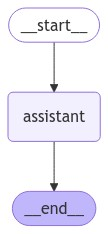

In [18]:
builder = StateGraph(MessagesState)
builder.add_node("assistant", assistant_with_trim)
builder.add_edge(START, "assistant")
builder.add_edge("assistant", END)

graph = builder.compile(checkpointer=memory)

display(Image(graph.get_graph().draw_mermaid_png()))

In [19]:
r = graph.invoke({"messages": messages_so_far}, config={"configurable": {"thread_id": 48}})


In [20]:
for item in r["messages"]:
    item.pretty_print()

================================ Human Message =================================

Hey AI can you answer some animal questions?
================================== Ai Message ==================================

Sure, go ahead and ask, I am here to assist
================================ Human Message =================================

I am interested to know which of the creatures currently inhabiting Earth has the longest lifespan. Which creature lives the longest?
================================== Ai Message ==================================

Ah, the quest for immortality through the animal kingdom! The creature with the longest lifespan is the ocean quahog clam (*Arctica islandica*), some of which have been known to live over 500 years. One particular clam, nicknamed "Ming," was found to be 507 years old! Talk about a slow pace of life.

If you're wondering about vertebrates, the Greenland shark (*Somniosus microcephalus*) holds the record, with some individuals estimated to live up

### Summarising instead of trimming or filtering

Let's try to summarise a previous conversation once it reaches a certain number of exchanges. Once we summarise we continuously add to the summary every n-new exchanges creating an inexhaustable context window.

We'll achieve this as follows:

- Add a model calling assistant which takes into account any existing summary + the conversation after.
- Add a summarisation node that creates a summary based on the conversation thus far and **deletes** all previous messages
- Add a conditional edge which either outputs the current conversation or creates a summary first and then calls the assistant


Setting up:

In [2]:
!pip install langchain_groq
!pip install -U transformers

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.5/106.5 kB 6.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.4/44.4 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 67.6 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 61.5 MB/s eta 0:00:00:00:01
  Attempting uninstall: tokenizers
    Found existing installation: tokenizers 0.19.1
    Uninstalling tokenizers-0.19.1:
      Successfully uninstalled tokenizers-0.19.1
  Attempting uninstall: transformers
    Found existing installation: transformers 4.42.4
    Uninstalling transformers-4.42.4:
      Successfully uninstalled transformers-4.42.4


In [5]:
!pip install langgraph-checkpoint-sqlite

In [4]:
from dotenv import load_dotenv, find_dotenv
_ = load_dotenv(find_dotenv()) # read local .env file
from langgraph.graph import MessagesState, START, END, StateGraph
from pprint import pprint
from langchain_core.messages import HumanMessage, SystemMessage, AIMessage
from langgraph.checkpoint.memory import MemorySaver
from langchain_openai import ChatOpenAI
from IPython.display import Image, display
from typing_extensions import TypedDict, Literal
from langchain_groq import ChatGroq
from langchain_core.messages import RemoveMessage, trim_messages
import sqlite3
from langgraph.checkpoint.sqlite import SqliteSaver
import json


The state (we extend the MessagesState with a new property 'summary'):

In [5]:
class State(MessagesState):
    summary: str;

# lets create the generic System Message as well:
sys_msg = SystemMessage('You are an everhelpful assistant trying to assist your human friend. You are polite, thoughtful \
and with great sense of nerdy humour.')

The Nodes:

- assistant
- summariser

In [6]:
def call_model(state: State):
    summary = state.get('summary', '')
    if summary:
        system_msg = SystemMessage(f'{sys_msg.content}\nSummary of our the conversation thus far:{summary}')
    else:
        system_msg = sys_msg
    result = llm.invoke([system_msg] + state['messages'])
    return {'messages': result}

def summariser(state: State):
    summary = state.get('summary', '')
    if summary:
        summary_message = f'Extend the current summary: {summary} with the conversation thus far.'
    else:
        summary_message = 'Summarise the conversation thus far'
    result = llm.invoke(state['messages'] + [HumanMessage(summary_message)])
    delete_messages = [RemoveMessage(id=m.id) for m in state["messages"][:-2]]
    return {'summary': result.content, 'messages': delete_messages}

        

The Condition:

In [4]:
def should_summarise(state: State) -> Literal['summariser', END]:
    if len(state['messages']) > 6:
        return "summariser"
    else:
        return END

Create the Graph with Memory!

In [5]:
# llm = ChatOpenAI(model="gpt-4o", temperature=0.75)
# llm = ChatGroq(model="llama-3.1-70b-versatile", temperature=0.5, model_kwargs={"top_p": 0.5})
conn = sqlite3.connect("./data/sqlite/memory-sum-example.db", check_same_thread=False)
memory = SqliteSaver(conn)
# memory = MemorySaver()


In [6]:
# What if we try and load a local model again!!
# It just does not work. We must overwrite the reducer of the MessagesState to use the correct template for Llama 3.1 instruct, 
# instead of the Chat template used.
import torch
from transformers import (
    AutoTokenizer,
    BitsAndBytesConfig,
    TrainingArguments,
    AutoModelForCausalLM,
    DataCollatorForLanguageModeling,
    GenerationConfig,
    pipeline
)
from langchain_huggingface import HuggingFacePipeline, ChatHuggingFace, HuggingFaceEndpoint

model_name = "../ext_models/Meta-Llama-3.1-8B-Instruct"
DEVICE = "cuda:0" if torch.cuda.is_available() else "cpu"

# model = AutoModelForCausalLM.from_pretrained(model_name, trust_remote_code=True, 
#                                              device_map=DEVICE, 
#                                              torch_dtype="auto")

generation_config = GenerationConfig.from_pretrained(model_name)
tokenizer = AutoTokenizer.from_pretrained(model_name)

stop_token = "<|eot_id|>"  
stop_token_id = tokenizer.encode(stop_token)[0]
begin_token = "<|begin_of_text|>"
begin_token_id = tokenizer.encode(begin_token)[0]
generation_config.eos_token_id = stop_token_id
generation_config.begin_token_id = begin_token_id
config = generation_config.to_dict()

trimmed_gen = {
    **config,
    "top_p": 0.9,  # changed from 0.15
    "temperature":0.1,
    "do_sample": False,  # changed from true
    "torch_dtype": torch.bfloat16,  # bfloat16
    "use_fast": True,
    "repetition_penalty": 1.1,
}

llm_pipeline = pipeline("text-generation", 
                        model=model_name,  
                        device_map=DEVICE,
                        torch_dtype=torch.bfloat16,
                        max_new_tokens=1024,
                        return_full_text=False) 
llm_pipeline.tokenizer.pad_token_id = llm_pipeline.model.config.eos_token_id = stop_token_id


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

> Note: **IMPORTANT**: Passing the tokenizer works wonders and the ChatHuggingFace seems to be fully operational for graph use. Still cannot work well with tools.. Perhaps I need to find another model.

In [7]:
open_llm_with_pipe = HuggingFacePipeline(pipeline=llm_pipeline, pipeline_kwargs=trimmed_gen)
llm = ChatHuggingFace(llm=open_llm_with_pipe, verbose=True, tokenizer=tokenizer)

In [6]:
# memory = MemorySaver()

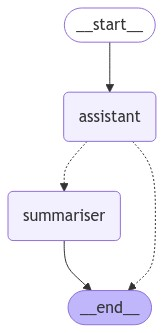

In [8]:
builder = StateGraph(State)
builder.add_node("assistant", call_model)
builder.add_node("summariser", summariser)
builder.add_edge(START, "assistant")
builder.add_conditional_edges("assistant", should_summarise)
builder.add_edge("summariser", END)

graph = builder.compile(checkpointer=memory)

display(Image(graph.get_graph().draw_mermaid_png()))

In [11]:
# messages = [HumanMessage("Hey AI can you answer some animal questions?"), AIMessage("Sure, go ahead and ask, I am here to assist")]
messages = [(HumanMessage("I am interested to know which of the creatures currently inhabiting Earth has the longest lifespan. \
In other words which creature lives the longest?"))]
config = {"configurable": {"thread_id": 45}}
r = graph.invoke({'messages': messages}, config=config)

Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


In [12]:
for item in r["messages"]:
    item.pretty_print()

================================ Human Message =================================

I am interested to know which of the creatures currently inhabiting Earth has the longest lifespan. In other words which creature lives the longest?
================================== Ai Message ==================================

My curious friend, you're asking about the ultimate record holder of longevity on our beloved planet Earth. I've got some fascinating news for you!

According to the latest scientific research, the creature that holds the record for the longest lifespan is... (dramatic pause)...the **Turritopsis dohrnii**, also known as the "immortal jellyfish"! However, this might not be exactly what you're looking for, as it's a type of jellyfish that can transform its body into a younger state through a process called transdifferentiation, essentially making it theoretically "immortal."

But if we're looking for a more traditional, non-regenerative creature with an impressive lifespan, the ti

In [13]:
r = graph.invoke({'messages': HumanMessage('Can you tell me more about a wonderful shark that lives hundreds of years, too?')}, config=config)

Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


In [14]:
for item in r["messages"]:
    item.pretty_print()

================================ Human Message =================================

I am interested to know which of the creatures currently inhabiting Earth has the longest lifespan. In other words which creature lives the longest?
================================== Ai Message ==================================

My curious friend, you're asking about the ultimate record holder of longevity on our beloved planet Earth. I've got some fascinating news for you!

According to the latest scientific research, the creature that holds the record for the longest lifespan is... (dramatic pause)...the **Turritopsis dohrnii**, also known as the "immortal jellyfish"! However, this might not be exactly what you're looking for, as it's a type of jellyfish that can transform its body into a younger state through a process called transdifferentiation, essentially making it theoretically "immortal."

But if we're looking for a more traditional, non-regenerative creature with an impressive lifespan, the ti

In [15]:
r = graph.invoke({'messages': HumanMessage('Wonderful! Thanks a lot for all this knowledge! What do you think is the oldest living creature that lives on land?')}, config=config)
for item in r["messages"]:
    item.pretty_print()

Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


================================ Human Message =================================

I am interested to know which of the creatures currently inhabiting Earth has the longest lifespan. In other words which creature lives the longest?
================================== Ai Message ==================================

My curious friend, you're asking about the ultimate record holder of longevity on our beloved planet Earth. I've got some fascinating news for you!

According to the latest scientific research, the creature that holds the record for the longest lifespan is... (dramatic pause)...the **Turritopsis dohrnii**, also known as the "immortal jellyfish"! However, this might not be exactly what you're looking for, as it's a type of jellyfish that can transform its body into a younger state through a process called transdifferentiation, essentially making it theoretically "immortal."

But if we're looking for a more traditional, non-regenerative creature with an impressive lifespan, the ti

In [16]:
r = graph.invoke({'messages': HumanMessage('Thats really cool! What wonderful trees! What about an old land dwelling animal? (or bird?)')}, config=config)
for item in r["messages"]:
    item.pretty_print()

Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


================================ Human Message =================================

Thats really cool! What wonderful trees! What about an old land dwelling animal? (or bird?)
================================== Ai Message ==================================

Let me tell you about the **Jonathan**, a Seychelles giant tortoise (Geochelone gigantea) that's been making headlines for its incredible age. Jonathan was born in 1882, which makes him... (dramatic pause)... **136 years old**! Yes, you read that right – 136 years young!

Jonathan lives on the island of Saint Helena, a British Overseas Territory in the South Atlantic Ocean. He's been a resident of the Saint Helena National Trust, a wildlife reserve, since 1882, and has become a beloved celebrity of sorts.

As a giant tortoise, Jonathan is a member of one of the longest-living animal species on land. They can live for up to 150 years or more in the wild, and their slow growth rate and low metabolic rate contribute to their remarkable l

In [32]:
r = graph.invoke({'messages': HumanMessage('Thank you sport! You have been a great assistance. I will ask some more questions later.')}, config=config)
for item in r["messages"]:
    item.pretty_print()

Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


================================ Human Message =================================

Thats really cool! What wonderful trees! What about an old land dwelling animal? (or bird?)
================================== Ai Message ==================================

Let me tell you about the **Jonathan**, a Seychelles giant tortoise (Geochelone gigantea) that's been making headlines for its incredible age. Jonathan was born in 1882, which makes him... (dramatic pause)... **136 years old**! Yes, you read that right – 136 years young!

Jonathan lives on the island of Saint Helena, a British Overseas Territory in the South Atlantic Ocean. He's been a resident of the Saint Helena National Trust, a wildlife reserve, since 1882, and has become a beloved celebrity of sorts.

As a giant tortoise, Jonathan is a member of one of the longest-living animal species on land. They can live for up to 150 years or more in the wild, and their slow growth rate and low metabolic rate contribute to their remarkable l

In [30]:
current_state = graph.get_state({"configurable": {"thread_id": 44}})

In [31]:
pprint(current_state[0])

{'messages': [HumanMessage(content='I am interested to know which of the creatures currently inhabiting Earth has the longest lifespan. In other words which creature lives the longest?', additional_kwargs={}, response_metadata={}, id='554019e1-4ee6-4bb0-ab29-004cdf9c6521'),
              HumanMessage(content='I am interested to know which of the creatures currently inhabiting Earth has the longest lifespan. In other words which creature lives the longest?', additional_kwargs={}, response_metadata={}, id='96764edd-f438-4bf1-afbb-4f0786890c06'),
              AIMessage(content='A question that\'s sure to make you live a little longer, knowing about the creatures that outlast us all. \n\nAccording to scientific records, the longest-living creature on Earth is the **Turritopsis dohrnii**, also known as the "immortal jellyfish." However, this one\'s lifespan is more about its ability to cheat death, rather than actually living forever. It can transform its body into a younger state through 